In [76]:
import numpy as np
from PIL import Image
import copy
import matplotlib.pyplot as plt

In [77]:
NUM_PX = 64
NUM_IMG = 500
TOTAL_NUM_IMG = 12500
CLASSES = {0:"dog", 1:"cat"}

In [78]:
def load_image(image_link):
    image = Image.open(image_link).resize((NUM_PX, NUM_PX))
    image_data = np.array(image)
    return image_data


def load_training_data():
    num_train_cat_images = NUM_IMG
    num_train_dog_images = NUM_IMG

    train_data_x = np.zeros((NUM_IMG * 2, NUM_PX, NUM_PX, 3))
    train_data_y = np.zeros((1, NUM_IMG*2))

    for i in range(num_train_cat_images):
        train_data_x[i] = load_image(f'./images/train/cat.{i}.jpg')
        train_data_y[0, i] = 1

    for i in range(num_train_dog_images):
        train_data_x[i + num_train_cat_images] = load_image(f'./images/train/dog.{i}.jpg')
        #train_data_y for dogs are already zero

    return train_data_x, train_data_y



In [79]:
def transform_data(x):
    x = x.reshape(x.shape[0], -1).T
    return standardize(x)

def standardize(x):
    return x / 255

In [80]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def initialize_parameters(dimension):
    weights = np.zeros((dimension, 1), dtype=float)
    bias = float(0)

    return weights, bias

In [81]:
def propagate(w, b, X, Y):
    m = X.shape[1]

    #forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / -m

    #back propagation
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m

    gradients = {
        "dw": dw,
        "db": db,
    }

    return gradients, cost

In [82]:
def optimize(w, b, X, Y, iterations=100, learning_rate=0.5):

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []
    gradients = None

    for i in range(iterations):
        gradients, cost = propagate(w, b, X, Y)

        w = w - learning_rate * gradients["dw"]
        b = b - learning_rate * gradients["db"]

        if i % 10000 == 0:
            costs.append(cost)
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {
        "w": w,
        "b": b,
    }

    return params, gradients, costs

In [83]:
def predict(w, b, X):

    m = X.shape[1]
    y_prediction = np.zeros((1, m))

    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(m):
        if A[0, i] > 0.5:
            y_prediction[0, i] = 1

    return y_prediction

In [84]:
def model(X_train, Y_train, X_test, Y_test, iterations=2000, learning_rate=0.01, print_cost=False):
    w, b = initialize_parameters(X_train.shape[0])

    params, gradients, costs = optimize(w, b, X_train, Y_train, iterations, learning_rate)
    w = params['w']
    b = params["b"]

    y_prediction_train = predict(w, b, X_train)
    y_prediction_test = predict(w, b, X_test)

    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - Y_test)) * 100))


    data = {"costs": costs,
         "Y_prediction_test": y_prediction_test,
         "Y_prediction_train" : y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "iterations": iterations}

    return data

In [85]:
def partition(x, y, percentage):
    m = x.shape[1]

    if m % 10 == 0:
        return np.concatenate((x[:, :int(m*percentage)//2], x[:, NUM_IMG:NUM_IMG+int(m*percentage)//2]), axis=1), \
               np.concatenate((y[0, :int(m*percentage)//2], y[0, NUM_IMG:NUM_IMG+int(m*percentage)//2]), axis=0), \
               np.concatenate((x[:, int(m*percentage)//2:NUM_IMG], x[:, NUM_IMG+int(m*percentage)//2:]), axis=1), \
               np.concatenate((y[0, int(m*percentage)//2:NUM_IMG], y[0, NUM_IMG+int(m*percentage)//2:]), axis=0)

    return  np.concatenate((x[:, :int(m*percentage)//2], x[:, NUM_IMG:NUM_IMG+int(m*percentage)//2]), axis=1), \
            np.concatenate((y[0, :int(m*percentage)//2], y[0, NUM_IMG:NUM_IMG+int(m*percentage)//2]), axis=0), \
            np.concatenate((x[:, (int(m*percentage)+1)//2:NUM_IMG], x[:, NUM_IMG+(int(m*percentage)+1)//2:]), axis=1), \
            np.concatenate((y[0, (int(m*percentage)+1)//2:NUM_IMG], y[0, NUM_IMG+(int(m*percentage)+1)//2:]), axis=0)

In [86]:
data_x, data_y = load_training_data()
data_x = transform_data(data_x)

In [87]:
train_x, train_y, test_x, test_y = partition(data_x, data_y, 0.7)
logistic_regression_model = model(train_x, train_y, test_x, test_y,
                                  iterations=40000, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 10000: 0.087130
Cost after iteration 20000: 0.049646
Cost after iteration 30000: 0.034434
train accuracy: 100.0 %
test accuracy: 49.0 %


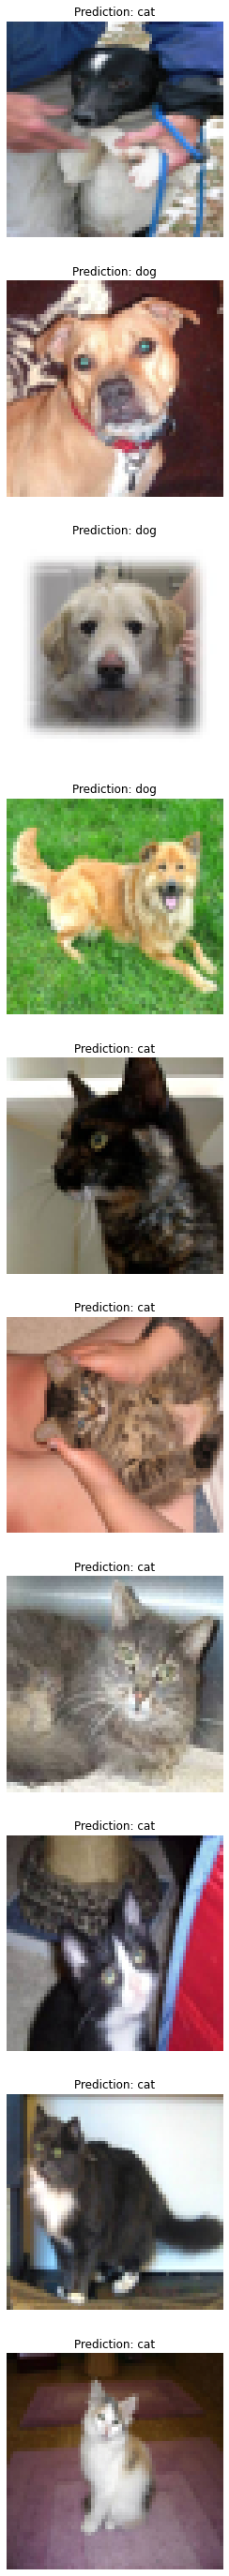

In [88]:
def predict_new_data(num_img, lr_model):
    w = lr_model['w']
    b = lr_model['b']

    x = np.zeros((num_img, NUM_PX, NUM_PX, 3))
    for i in range(num_img):
        x[i] = load_image(f'./images/test/{i+1}.jpg')


    fig = plt.figure(figsize=(num_img*10, 50))
    rows = num_img
    columns = 1

    x_transformed = transform_data(x)

    y_prediction = predict(w, b, x_transformed)

    for i in range(num_img):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(Image.fromarray(np.uint8(x[i])).convert('RGB'))
        plt.axis('off')
        plt.title(f'Prediction: {CLASSES[y_prediction[0,i]]}')


predict_new_data(10, logistic_regression_model)